In [10]:
import warnings
import json
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np
from scipy.stats import norm
import torch
from torch.utils.data import DataLoader
import pickle
import os


from varpi.wasserstein_min import get_best_lstm_pdf_params
from varpi.tain_varpi import VarPi
from varpi.varpi_utils.varphi_utils import get_all_quantiles
from utils.dist_utils import generate_smooth_pdf
from utils.optuna_utils import load_qlstm_model
from utils.data_utils import get_test_dataset

warnings.filterwarnings("ignore")

with open("config.json", "r") as f:
    CONFIG = json.load(f)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

taus = CONFIG["general"]["quantiles"]

val_start_date = CONFIG["general"]["dates"]["validation_period"]["start_date"]
val_end_date = CONFIG["general"]["dates"]["validation_period"]["end_date"]

seed = CONFIG["general"]["seed"]
np.random.seed(seed)
torch.manual_seed(seed)

In [11]:
varPhi_q, qlstm_params = load_qlstm_model()
varPhi_q.load_state_dict(torch.load('models/qlstm_model.pth'))
varPhi_q = varPhi_q.to(DEVICE)
pdf_params = get_best_lstm_pdf_params(None)

[I 2025-01-23 19:14:42,126] Using an existing study with name 'wasserstein_distance_qlstm' instead of creating a new one.


In [12]:
normalization_window = qlstm_params['normalazation_window']
val_dataset = get_test_dataset(normalization_lookback=normalization_window,
                                    start_date=val_start_date,
                                    end_date=val_end_date,
                                    lookforward=30,
                                    test=True)
val_quantiles = get_all_quantiles(val_dataset, varPhi_q)

Inferencing models: 100%|██████████| 6/6 [00:25<00:00,  4.21s/it]


In [158]:
idx = np.random.randint(0, len(val_quantiles["currency pairs"]["observed_returns"]))
obs_rets = val_quantiles["currency pairs"]["observed_returns"][idx]
future_rets = val_quantiles["currency pairs"]["future_returns"][idx]
quants = val_quantiles["currency pairs"]["all_pred_quantiles"][idx]
idx

712

In [188]:
grid, pdf, cdf = generate_smooth_pdf(quants, np.array(taus), **pdf_params)
quants_mean = np.mean(quants, axis=0)
quants_std = np.std(quants, axis=0)

new_quants = np.array([q + np.random.normal(0, 0.001) for q in quants])
new_grid, new_pdf, new_cdf = generate_smooth_pdf(new_quants, np.array(taus), **pdf_params, grid_points=1000)

standard_mean = np.trapz(grid * pdf, grid)
standard_std = np.sqrt(np.trapz(grid ** 2 * pdf, grid) - standard_mean ** 2)

new_mean = np.trapz(new_grid * new_pdf, new_grid)
new_std = np.sqrt(np.trapz(new_grid ** 2 * new_pdf, new_grid) - new_mean ** 2)

print(f"Standard Mean: {standard_mean:.6f}, Standard Std: {standard_std:.6f}")
print(f"New Mean: {new_mean:.6f}, New Std: {new_std:.6f}")

Standard Mean: 0.000654, Standard Std: 0.031859
New Mean: 0.000630, New Std: 0.031760


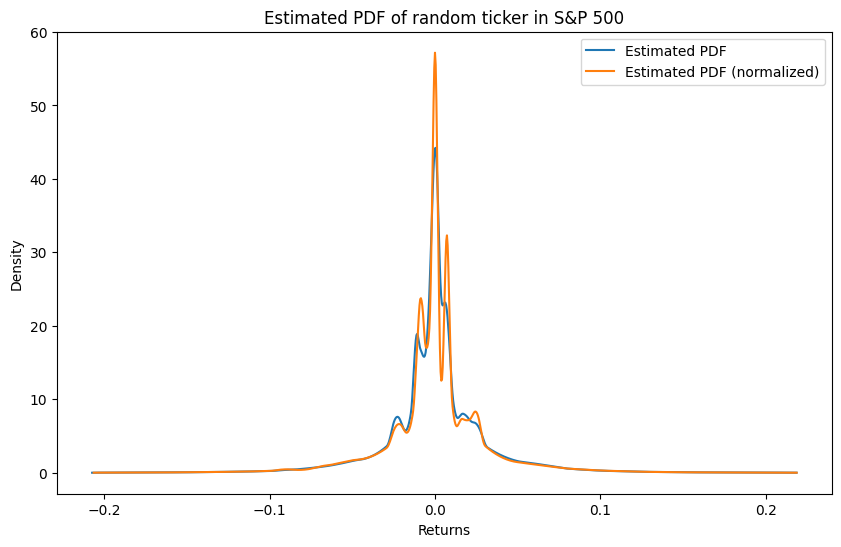

In [189]:
plt.figure(figsize=(10, 6))
plt.plot(grid, pdf, label="Estimated PDF")
plt.plot(new_grid, new_pdf, label="Estimated PDF (normalized)")
plt.ylabel("Density")
plt.xlabel("Returns")
plt.title("Estimated PDF of random ticker in S&P 500")
plt.legend()
plt.show()

In [162]:
varPi_q = torch.load('models/varpi.pth').to(DEVICE)

In [194]:
t = 1
T = 30
t_quants = torch.tensor(new_quants).float().to(DEVICE).view(1, -1)
t_prime = torch.tensor([[t/T]]).float().to(DEVICE)
T_prime = torch.tensor([[T/30]]).float().to(DEVICE)

In [195]:
qu = varPi_q(t_quants, t_prime, T_prime)

In [196]:
pi_grid, pi_pdf, pi_cdf = generate_smooth_pdf(qu.cpu().detach().numpy().flatten(), np.array(taus), **pdf_params)

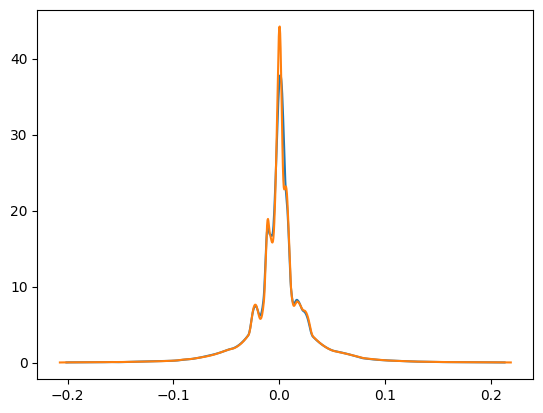

In [197]:
plt.plot(pi_grid, pi_pdf)
plt.plot(grid, pdf)

In [568]:
min_price = 1.07
max_price = 432.07
sampled_price = torch.rand(1) * (max_price - min_price) + min_price

In [569]:
sampled_price

tensor([264.4940])

In [579]:
np.sqrt(np.exp(standard_std + (np.random.normal(1) * (standard_std/10))) - 1)

np.float64(0.17989705989280322)

In [630]:
standard_std + np.random.normal(1) * (standard_std/10)

np.float64(0.030810900770973874)

In [632]:
standard_std

np.float64(0.03185940733705761)

: 

In [629]:
np.random.normal(1)* (standard_std/10)

np.float64(0.004736604168771634)